#Reporting summary: 
1. Background: The number of suicides during the COVID-19 pandemic looks extremely higher than in the previous trends.

2. Research Question: 
Is the number of suicides in Japan during the pandemic abnormally higher statistically significantly?
3. Data: https://www.npa.go.jp/publications/statistics/safetylife/jisatsu.html
4. Methods: Create the forecasting model with the data of pre COVID-19 periods and predict the number of suicides during the pandemic. We use the two models: SARIMA and Prophet. If there are significant deviations of the actual series from the predicted series, we can say the number of suicides in Japan during the pandemic is abnormal and it indicates there is a potential driver for that huge change.
  - Ref1: https://ai-trend.jp/basic-study/time-series-analysis/sarima_model/
  - Ref2: https://facebook.github.io/prophet/docs/quick_start.html#python-api
5. Results & Conclusion: See the both charts. Both models show the actual number of suicides during the pandemic is deviated from the 95% Confidence Interval of the generated model. This means the trend during the pandemic is abnormally higher compared with the pre COVID-19 periods.


# Import the libraries and data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import *
from scipy.stats import describe
import itertools
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings
warnings.simplefilter('ignore')

path = "..\data"

Importing plotly failed. Interactive plots will not work.


In [4]:
df = pd.DataFrame({"num_suicide": pd.read_pickle(path+"/02_intermediate/nation_suicide.pickle")})

# Split the data into before_COVID and with_COVID
train_start = "2015-01"
train_end = "2020-02"
test_start = (datetime.strptime(train_end, '%Y-%m') + relativedelta(months=1)).strftime("%Y-%m")
test_end = "2022-02"
df_train = df[train_start: train_end]
df_test = df[test_start: test_end]

# Num of lags to be considered
DV_shifts = 0

# SARIMA
Reference: https://ai-trend.jp/basic-study/time-series-analysis/sarima_model/

The model that has the best AIC score:  [(0, 1, 1), (1, 1, 1, 12), 418.9249861375218]
                                     SARIMAX Results                                      
Dep. Variable:                        num_suicide   No. Observations:                   62
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -289.723
Date:                            Fri, 30 Sep 2022   AIC                            587.446
Time:                                    02:52:45   BIC                            595.013
Sample:                                01-01-2015   HQIC                           590.317
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7173      0

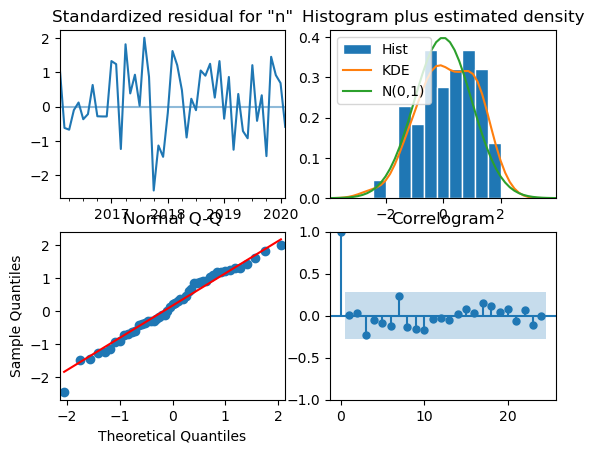

In [5]:
# Set up the range of hyperparams
p = d = q = range(2)
sp = sd = sq = range(2)
 
# Create the list composed of all the patterns of p, d, q
pdq = list(itertools.product(p, d, q))

# Assign 12 as the argument for seasonality because of its yearly trend
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))]

# Choose the best model in terms of Akaike Information Criterion
best_result = [0, 0, 1e10]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df_train,
                          order = param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
 
            results = mod.fit()
             
            #print('order{}, s_order{} - AIC: {}'.format(param, param_seasonal, results.aic))
 
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
             
print('The model that has the best AIC score: ', best_result)

# Re-build the SARIMA model with the above best hyperparams
mod = SARIMAX(df_train,
              order = best_result[0],
              seasonal_order=best_result[1],
              enforce_stationarity=True,
              enforce_invertibility=True)
 
results = mod.fit()
print(results.summary())

# Check the validity of the SARIMA model
results.plot_diagnostics(lags=24);

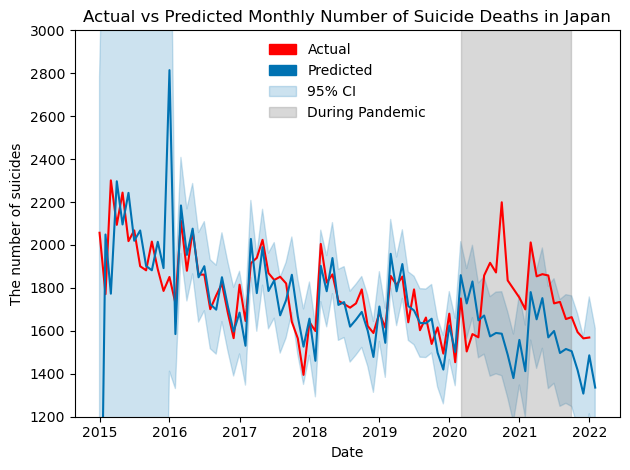

In [6]:
# Get the prediction
pred = results.get_prediction(start=train_start, end = test_end, dynamic=False)

# Extract the series of both the point prediction and interval prediction
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha = .05)

# Visualize the results
fig, ax = plt.subplots()
ax.plot(df[train_start: test_end]["num_suicide"], label="Actuals", color="r")
ax.plot(pred_mean, label='forecast', color = "#0072B2")

plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#0072B2', alpha=.2)
ax.set_title("Actual vs Predicted Monthly Number of Suicide Deaths in Japan")
ax.set_xlabel("Date")
ax.set_ylabel("The number of suicides")
ax.set_ylim([1200, 3000])
ax.axvspan(datetime(2020,3,1), datetime(2021,9,30), color='gray', alpha=0.3)
red_patch = mpatches.Patch(color='red', label='Actual')
blue_patch = mpatches.Patch(color='#0072B2', label='Predicted')
skyblue_patch = mpatches.Patch(color='#0072B2', alpha=0.2, label='95% CI')
gray_patch = mpatches.Patch(color='gray', alpha=0.3, label='During Pandemic')
ax.legend(handles=[red_patch, blue_patch, skyblue_patch, gray_patch]).get_frame().set_linewidth(0.0001)
fig.tight_layout()
plt.savefig(path+"/08_reporting/num_suicide_SARIMA.png", format="png", dpi=1000);

# Facebook Prophet
Reference: https://facebook.github.io/prophet/docs/quick_start.html#python-api

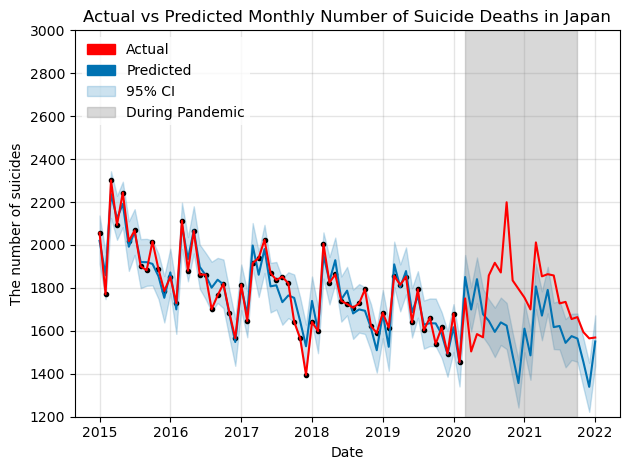

In [7]:
# Create the dataset for Prophet
full = df.reset_index().rename({"Date": "ds", "num_suicide": "y"}, axis=1)[["ds", "y"]].set_index("ds")
full[full.columns[~full.columns.isin(["y"])]] = full.drop("y",axis=1).shift(DV_shifts)
full_preprocessed = full[DV_shifts:]

# Split the data into train and test and reset the index
train = full_preprocessed[train_start: train_end].reset_index()
test = full_preprocessed[test_start: test_end].reset_index()

# Instantiate the model
prophet_uni = Prophet(interval_width=0.95, weekly_seasonality=False, daily_seasonality=False)

# Fit the train data to the model
prophet_uni.fit(train)

# Create the future dataframe
future_uni = prophet_uni.make_future_dataframe(periods=len(test)+1, freq="MS")

# Make a predicition
forecast_uni = prophet_uni.predict(future_uni)

# Plot Actual VS Prediction
fig, ax = plt.subplots()
prophet_uni.plot(forecast_uni, ax=ax)
ax.plot(full_preprocessed[train_start: test_end]["y"], label="Actual", color="r")
ax.set_title("Actual vs Predicted Monthly Number of Suicide Deaths in Japan")
ax.set_xlabel("Date")
ax.set_ylabel("The number of suicides")
ax.set_ylim([1200, 3000])
ax.axvspan(datetime(2020,3,1), datetime(2021,9,30), color='gray', alpha=0.3)
red_patch = mpatches.Patch(color='red', label='Actual')
blue_patch = mpatches.Patch(color='#0072B2', label='Predicted')
skyblue_patch = mpatches.Patch(color='#0072B2', alpha=0.2, label='95% CI')
gray_patch = mpatches.Patch(color='gray', alpha=0.3, label='During Pandemic')
ax.legend(handles=[red_patch, blue_patch, skyblue_patch, gray_patch]).get_frame().set_linewidth(0.0001)
fig.tight_layout()
plt.savefig(path+"/08_reporting/num_suicide_Prophet.png", format="png", dpi=1000);